In [1]:
import random
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class OneLaneTrafficSimulation:
    def __init__(self, length = 100, density = 0.3, Vmax = 5, p_slowdown = 0.2, num_of_lanes = 1):
        self.length = length
        self.density = density
        self.Vmax = Vmax
        self.p_slowdown = p_slowdown
        self.num_of_lanes = num_of_lanes
        self.current_state = -np.ones((self.num_of_lanes, self.length), dtype = int)
        self.time = 0
        self.sum_cars_get_through = 0
        self.flow = 0.
    
    def random_initialize(self):
    # initialize the current state by putting random cars on the road
    # the number of cars is domained by the density
    # velocity of each car is random
        num_of_cars = int(self.num_of_lanes * self.length * self.density)
        random_lane_indices = np.random.randint(self.num_of_lanes, size=int(num_of_cars))
        random_pos_indices = np.random.randint(self.length, size=int(num_of_cars))
        for i in range(num_of_cars):
            self.current_state[random_lane_indices[i], random_pos_indices[i]] = int(np.random.normal((self.Vmax + 1) / 2, 1))
    def uniform_initialize(self):
        # put cars on the road with maximum velocity and interval corresponding to maximum velocity
        a=1
    def uniform_initialize(self):
    # put cars on the road with maximum velocity and interval corresponding to maximum velocity
        i = 0
        while i < self.length - self.Vmax - 1:
            for j in range(self.num_of_lanes):
                self.current_state[j, i] = self.Vmax
            i += self.Vmax + 1
        self.density = np.sum(self.current_state != -1)
        self.p_slowdown = 0
    
    def sim_iteration(self):
        # update velocity
        for lane in range(self.num_of_lanes):
            positions = np.where(self.current_state[lane] != -1)[0]
            for i in range(positions.shape[0]):
                if i < positions.shape[0] - 1:
                    gap = positions[i + 1] - positions[i] - 1
                else:
                    gap = positions[0] - positions[i] + self.length - 1
                # accelerate if gap allows
                if self.current_state[lane, positions[i]] < self.Vmax and gap >= self.current_state[lane, positions[i]] + 1:
                    self.current_state[lane, positions[i]] += 1
                # slowdown if gap doesn't allow vehiels to accelerate or maintain max velocity
                if gap < self.current_state[lane, positions[i]] + 1:
                    self.current_state[lane, positions[i]] = gap if gap > 0 else 0
                # random slowdown according to the probability of p_slowdown
                if self.current_state[lane, positions[i]] > 0 and np.random.random() < self.p_slowdown:
                    self.current_state[lane, positions[i]] -= 1
        # update positions according to updated velocity
        # vehicels appears from the left of the road if hits the right end
        next_state = -np.ones(self.current_state.shape, dtype = int)
        for lane in range(self.num_of_lanes):
            positions = np.where(self.current_state[lane] != -1)[0]
            for pos in positions:
                next_pos = (pos + self.current_state[lane, pos]) % self.length
                next_state[lane, next_pos] = self.current_state[lane, pos]
        self.current_state = next_state
        
        # update time and calculate flow
        # time increase every iteration
        # num of totoal cars get through increase when car pass the right end of the road
        self.time += 1
        for lane in range(self.num_of_lanes):
            positions = np.where(self.current_state[lane] != -1)[0]
            if self.current_state[lane, positions[0]] > positions[0]:
                self.sum_cars_get_through += 1
        self.flow = self.sum_cars_get_through / (self.time * self.num_of_lanes)

In [3]:
class MultiLaneTrafficSimulation:
    def __init__(self, length = 100, density = 0.3, Vmax = 5, p_slowdown = 0.2, num_of_lanes = 3, p_change_lane = 1, l_safety = 3):
        self.length = length
        self.density = density
        self.Vmax = Vmax
        self.p_slowdown = p_slowdown
        self.num_of_lanes = num_of_lanes
        self.current_state = -np.ones((self.num_of_lanes, self.length), dtype = int)
        self.p_change_lane = p_change_lane
        self.l_safety = l_safety
        self.time = 0
        self.sum_cars_get_through = 0
        self.flow = 0.

    def random_initialize(self):
        # initialize the current state by putting random cars on the road, the number of cars is domained by the density
        num_of_cars = int(self.num_of_lanes * self.length * self.density)
        random_lane_indices = np.random.randint(self.num_of_lanes, size=int(num_of_cars))
        random_pos_indices = np.random.randint(self.length, size=int(num_of_cars))
        for i in range(num_of_cars):
            self.current_state[random_lane_indices[i], random_pos_indices[i]] = int(np.random.normal((self.Vmax + 1) / 2, 1))
    
    def uniform_initialize(self):
        # put cars on the road with maximum velocity and interval corresponding to maximum velocity
        a=1
    def uniform_initialize(self):
        # put cars on the road with maximum velocity and interval corresponding to maximum velocity
        i = 0
        while i < self.length - self.Vmax - 1:
            for j in range(self.num_of_lanes):
                self.current_state[j, i] = self.Vmax
            i += self.Vmax + 1
        self.density = np.sum(self.current_state != -1)
        self.p_slowdown = 0

    def change_lane_nochange(self):
        a = 1

    def change_lane_righthand(self):
    # drivers tend to drive on the right lane and overtake on the left lane
        positions = []
        for lane in range(self.num_of_lanes):
            positions_of_lane = np.where(self.current_state[lane] != -1)[0]
            positions.append(positions_of_lane)
        
        for lane in range(self.num_of_lanes):
            left_lane = max(lane - 1, 0)
            right_lane = min(lane + 1, self.num_of_lanes - 1)
            for i in range(positions[lane].shape[0]):
                # gap is the distance from the front car
                if i < positions[lane].shape[0] - 1:
                    gap = positions[lane][i + 1] - positions[lane][i] - 1
                else:
                    gap = positions[lane][0] - positions[lane][i] + self.length - 1
                
                # gap_left_front is distance from the front car in the left lane
                # gap_right_front is distance from the front car in the right lane
                # gap_left_behind is distance from the behind car in the left lane
                # gap_right_behind is distance from the behind car in the right lane
                left_front_index = 0
                right_front_index = 0
                for j in range(positions[left_lane].shape[0]):
                    if positions[left_lane][j] > positions[lane][i]:
                        left_front_index = j
                        break
                if positions[left_lane].shape[0] != 0:
                    gap_left_front = (positions[left_lane][left_front_index] - positions[lane][i] - 1) % self.length
                    gap_left_behind = (positions[lane][i] - positions[left_lane][left_front_index - 1] - 1) % self.length
                else:
                    gap_left_front = self.length
                    gap_left_behind = self.length
                
                for j in range(positions[right_lane].shape[0]):
                    if positions[right_lane][j] > positions[lane][i]:
                        right_front_index = j
                        break
                if positions[right_lane].shape[0] != 0:
                    gap_right_front = (positions[right_lane][right_front_index] - positions[lane][i] - 1) % self.length
                    gap_right_behind = (positions[lane][i] - positions[right_lane][right_front_index - 1] - 1) % self.length
                else:
                    gap_right_front = self.length
                    gap_right_behind = self.length
    
                # verify the condtions to change lane
                left_cond = 1
                right_cond = 1
                
                right_cond &= gap_right_front > min(self.current_state[lane, positions[lane][i]] + 1, self.Vmax) # can accelerate on the right lane
                right_cond &= gap_right_behind > self.l_safety # safety condition
                right_cond &= self.current_state[right_lane, positions[lane][i]] == -1 # vacancy in the right lane
    
                left_cond &= gap < min(self.current_state[lane, positions[lane][i]] + 1, self.Vmax) # unable to accelerate
                left_cond &= gap < gap_left_front # larger gap in the left lane
                left_cond &= gap_left_behind > self.l_safety # safety condition
                left_cond &= self.current_state[left_lane, positions[lane][i]] == -1 # vacancy in the left lane
                
                if right_cond == 1:
                    target_lane = right_lane
                elif left_cond == 1:
                    target_lane = left_lane
                else:
                    target_lane = -1
                if target_lane != -1:
                    if np.random.random() < self.p_change_lane:
                        self.current_state[target_lane, positions[lane][i]] = self.current_state[lane, positions[lane][i]]
                        self.current_state[lane, positions[lane][i]] = -1

    def change_lane_free(self):
    # drivers choose to change to left or right lane freely
        positions = []
        for lane in range(self.num_of_lanes):
            positions_of_lane = np.where(self.current_state[lane] != -1)[0]
            positions.append(positions_of_lane)
        
        for lane in range(self.num_of_lanes):
            left_lane = max(lane - 1, 0)
            right_lane = min(lane + 1, self.num_of_lanes - 1)
            for i in range(positions[lane].shape[0]):
                # gap is the distance from the front car
                if i < positions[lane].shape[0] - 1:
                    gap = positions[lane][i + 1] - positions[lane][i] - 1
                else:
                    gap = positions[lane][0] - positions[lane][i] + self.length - 1
                
                # gap_left_front is distance from the front car in the left lane
                # gap_right_front is distance from the front car in the right lane
                # gap_left_behind is distance from the behind car in the left lane
                # gap_right_behind is distance from the behind car in the right lane
                left_front_index = 0
                right_front_index = 0
                
                for j in range(positions[left_lane].shape[0]):
                    if positions[left_lane][j] > positions[lane][i]:
                        left_front_index = j
                        break
                gap_left_front = (positions[left_lane][left_front_index] - positions[lane][i] - 1) % self.length
                gap_left_behind = (positions[lane][i] - positions[left_lane][left_front_index - 1] - 1) % self.length
        
                for j in range(positions[right_lane].shape[0]):
                    if positions[right_lane][j] > positions[lane][i]:
                        right_front_index = j
                        break
                gap_right_front = (positions[right_lane][right_front_index] - positions[lane][i] - 1) % self.length
                gap_right_behind = (positions[lane][i] - positions[right_lane][right_front_index - 1] - 1) % self.length
        
                # verify the condtions to change lane
                cond = 1
                left_cond = 1
                right_cond = 1
                
                left_cond &= gap < gap_left_front # larger gap in the left lane
                left_cond &= gap_left_behind > self.l_safety # safety condition
                left_cond &= self.current_state[left_lane, positions[lane][i]] == -1 # vacancy in the left lane
                
                right_cond &= gap < gap_right_front # larger gap in the right lane
                right_cond &= gap_right_behind > self.l_safety # safety condition
                right_cond &= self.current_state[right_lane, positions[lane][i]] == -1 # vacancy in the right lane
        
                cond &= gap < min(self.current_state[lane, positions[lane][i]] + 1, self.Vmax) # unable to accelerate
                cond &= left_cond | right_cond
                
                if cond:
                    if left_cond & right_cond == 1:
                        target_lane = left_lane if gap_left_front > gap_right_front else right_lane
                    elif left_cond == 1:
                        target_lane = left_lane
                    else:
                        target_lane = right_lane
                    if np.random.random() < self.p_change_lane:
                        self.current_state[target_lane, positions[lane][i]] = self.current_state[lane, positions[lane][i]]
                        self.current_state[lane, positions[lane][i]] = -1
    
    def sim_iteration(self, change_lane_function):
        # change lane
        # if self.num_of_lanes > 1:
        # self.change_lane_righthand()
        if self.num_of_lanes > 1:
            change_lane_function()
        
        # update velocity
        for lane in range(self.num_of_lanes):
            positions = np.where(self.current_state[lane] != -1)[0]
            for i in range(positions.shape[0]):
                if i < positions.shape[0] - 1:
                    gap = positions[i + 1] - positions[i] - 1
                else:
                    gap = positions[0] - positions[i] + self.length - 1
                # accelerate
                if self.current_state[lane, positions[i]] < self.Vmax and gap >= self.current_state[lane, positions[i]] + 1:
                    self.current_state[lane, positions[i]] += 1
                # slowdown
                if gap < self.current_state[lane, positions[i]] + 1:
                    self.current_state[lane, positions[i]] = gap if gap > 0 else 0
                #random slowdown
                if self.current_state[lane, positions[i]] > 0 and np.random.random() < self.p_slowdown:
                    self.current_state[lane, positions[i]] -= 1
                
        #update positions
        next_state = -np.ones(self.current_state.shape, dtype = int)
        for lane in range(self.num_of_lanes):
            positions = np.where(self.current_state[lane] != -1)[0]
            for pos in positions:
                next_pos = (pos + self.current_state[lane, pos]) % self.length
                next_state[lane, next_pos] = self.current_state[lane, pos]
        self.current_state = next_state
        
        # update time and calculate flow
        self.time += 1
        for lane in range(self.num_of_lanes):
            positions = np.where(self.current_state[lane] != -1)[0]
            if positions.shape[0] != 0 and self.current_state[lane, positions[0]] > positions[0]:
                self.sum_cars_get_through += 1
        self.flow = self.sum_cars_get_through / (self.time * self.num_of_lanes)

In [4]:
def state_to_text_single(state):
    # Converts the single-lane traffic state array into string format
    line = ""
    for cell in state[0]:
        if cell == -1:
            line += "."
        else:
            line += str(cell)
    return line

sim_single = OneLaneTrafficSimulation(length=100, density=0.3, Vmax=5, num_of_lanes=1)
sim_single.random_initialize()

# Run and collect snapshots
snapshots_single = []
for _ in range(100):
    sim_single.sim_iteration()
    snapshots_single.append(state_to_text_single(sim_single.current_state))

# Combine all snapshots into single-lane visual output
visual_single = "\n".join(snapshots_single)
print(visual_single)


.....1...3...00.1..1.1.1...3....300.1........4.......3.....200..2.....5..2...3.0...3....3....1...3..
3......2....30.1..2.1.1..2.....4000...2...........5......4.00.1...2.....2...3.1.1.....3....3...2....
....4.....3.0.1..2.1.1..2...3..000.1.....3.............5..10.1..2....3.....3.1.1..2.......4...3...3.
.3.......5.1.1..2.1.1.1....3..200.1..2......3............20.1..2...3.....4..1.1.1....3.......3...3..
.....4....1.1..2.1.1.1..2....200.1..2...3.......4........0.1..2...3....4...2.1.1.1.......4......3..2
..3......4.1..2.1.1.1..2...3.00.1..2...3....4........5....1.1...2.....4...30..1.1..2..........5...2.
2....3...0...2.1.1.1.1...2.0.0.1..2...3...3......5......3..1..2....3.....30.1..1..2...3..........3..
...3....3.1..0..1.10...2..1.1.1..2...3...3....4......4....2.1....3.....4.0.1..2..2...3....4........2
..3....4.1.1.0...10.1....20..1..2..2....3....4.....5....3..1.1.......4..1.1.1...2...3....4.....5....
5.....4.10.0.0...00...2..00....2..2...3.....4....4.....4..2.1..2.......2.1.1.1.....3....4..

In [5]:
def state_to_text_multi(state):
    # Converts the multi-lane traffic state array into string format with a blank line every 3 lanes
    lines = []
    for i, lane in enumerate(state):
        line = ""
        for cell in lane:
            if cell == -1:
                line += "."
            else:
                line += str(cell)
        lines.append(line)
        if (i + 1) % 3 == 0:
            lines.append("")  # add blank line after every 3 lanes
    return "\n".join(lines)

sim_multi = MultiLaneTrafficSimulation(length=100, density=0.3, Vmax=5, num_of_lanes=6, p_change_lane=1)
sim_multi.random_initialize()

# Run and collect snapshots
snapshots_multi = []
for _ in range(30):
    sim_multi.sim_iteration(sim_multi.change_lane_righthand)
    snapshots_multi.append(state_to_text_multi(sim_multi.current_state))

# Combine all snapshots into multi-lane visual output
visual_multi = "\n".join(snapshots_multi)
print(visual_multi)


...3.....3.......00.1..........4.1...3..2...0.....40...3..........4....2.....3...3.0...3...10....4..
.30.1....4....3...2.1000...3.........30.1..2....3.0..2............4...3...3..2....30.1....4..2...0..
..1....4....3.....0...3..............5..000...3......3...3...00...3.......3......0..2...3..1.1....4.

...3..2..2.....3...............3.0.1.1.1..2...10.1.10...3.0...30....4....3.....3...3....3......40.1.
..4.1..2..2..20...3....3....2..0.1.1..2..1...3......1.1....4..2....4....4....2..1...3...3......4....
..200..20...3..1...2..........4..0.10..2...2.......1.1..2.1.1..2..2......3......3..2....200...3....0

.4.....4.....4...0.1..2.............5..2...30.....0.1......4..........4...3....2..1.1.....30.1......
.0.1..2......4..2..1000.1..........2.0.1..2..2...10.....3.....1......3...3..2..2..0.1..2....2...3.1.
2...2.....3....3..0...........3....4...2000......3.0....3....4.1......4.......4...1....3..2.1.1.....

2....2..2..2.......4......4.......1.1.1..2..2.0.1.1..1..0..1..0.1.......4...3.....3....4

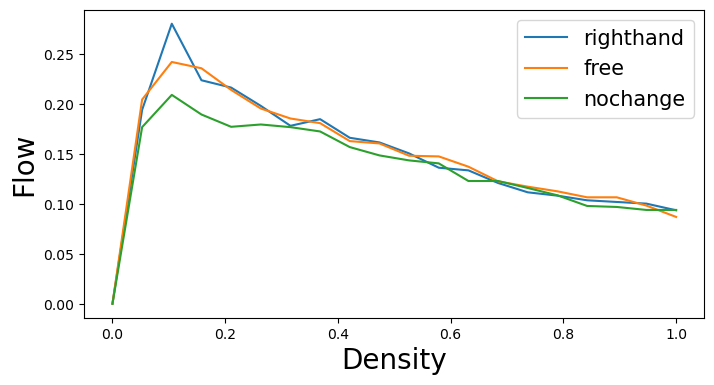

In [6]:
def visulization_density2flow():
    precision = 20
    num_of_sim = 10
    num_of_ite = 100
    densities = np.linspace(0, 1, precision)
    flows_righthand = np.zeros(precision)
    flows_free = np.zeros(precision)
    flows_nochange = np.zeros(precision)
    for i in range(precision):
        # print("density:", densities[i])
        sum_of_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(density = densities[i], p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_righthand)
            sum_of_flow += sim.flow
        flows_righthand[i] = sum_of_flow / num_of_sim
    
    for i in range(precision):
        # print("density:", i)
        sum_of_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(density = densities[i], p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_free)
            sum_of_flow += sim.flow
        flows_free[i] = sum_of_flow / num_of_sim
        
    for i in range(precision):
        # print("density:", i)
        sum_of_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(density = densities[i], p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_nochange)
            sum_of_flow += sim.flow
        flows_nochange[i] = sum_of_flow / num_of_sim
    
    plt.figure(figsize = (8, 4))
    plt.plot(densities, flows_righthand, label = 'righthand')
    plt.plot(densities, flows_free, label = 'free')
    plt.plot(densities, flows_nochange, label = 'nochange')
    plt.xlabel("Density", fontsize = 20)
    plt.ylabel("Flow", fontsize = 20)
    plt.legend(fontsize = 15)
    plt.show()
    
visulization_density2flow()

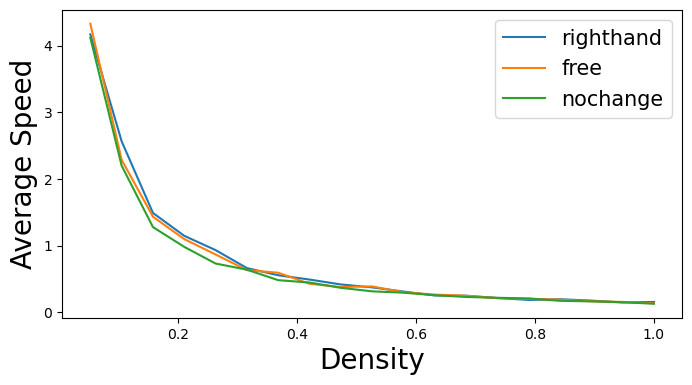

In [7]:
def visulization_density2avg_speed():
    precision = 20
    num_of_sim = 10
    num_of_ite = 100
    densities = np.linspace(0, 1, precision)
    speeds_righthand = np.zeros(precision)
    speeds_free = np.zeros(precision)
    speeds_nochange = np.zeros(precision)

    for i in range(precision):
        sum_speed = 0.
        count = 0
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(density = densities[i], p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_righthand)
            sum_speed += np.sum(sim.current_state[sim.current_state >= 0])
            count += np.sum(sim.current_state >= 0)
        speeds_righthand[i] = sum_speed / count if count > 0 else 0

    for i in range(precision):
        sum_speed = 0.
        count = 0
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(density=densities[i], p_slowdown=0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_free)
            sum_speed += np.sum(sim.current_state[sim.current_state >= 0])
            count += np.sum(sim.current_state >= 0)
        speeds_free[i] = sum_speed / count if count > 0 else 0

    for i in range(precision):
        sum_speed = 0.
        count = 0
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(density = densities[i], p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_nochange)
            sum_speed += np.sum(sim.current_state[sim.current_state >= 0])
            count += np.sum(sim.current_state >= 0)
        speeds_nochange[i] = sum_speed / count if count > 0 else 0

    start_index = np.argmax(speeds_righthand)
    densities = densities[start_index:]
    speeds_righthand = speeds_righthand[start_index:]
    speeds_free = speeds_free[start_index:]
    speeds_nochange = speeds_nochange[start_index:]
    
    plt.figure(figsize = (8, 4))
    plt.plot(densities, speeds_righthand, label = 'righthand')
    plt.plot(densities, speeds_free, label = 'free')
    plt.plot(densities, speeds_nochange, label = 'nochange')
    plt.xlabel("Density", fontsize = 20)
    plt.ylabel("Average Speed", fontsize = 20)
    plt.legend(fontsize = 15)
    plt.show()
    
visulization_density2avg_speed()

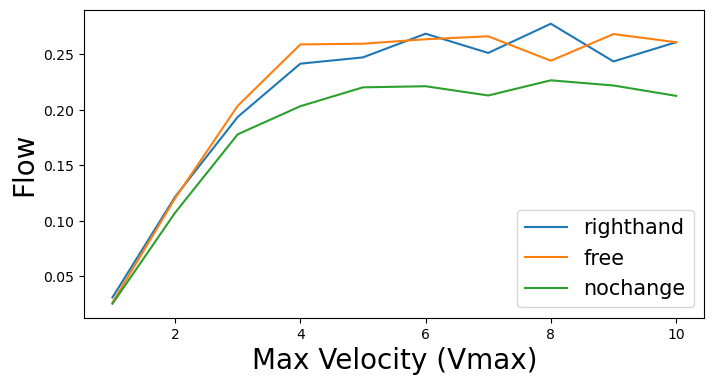

In [8]:
def visulization_vmax2flow():
    vmax_values = np.arange(1, 11)  # Vmax from 1 to 10
    num_of_sim = 10
    num_of_ite = 100
    flows_righthand = np.zeros(len(vmax_values))
    flows_free = np.zeros(len(vmax_values))
    flows_nochange = np.zeros(len(vmax_values))

    for i in range(len(vmax_values)):
        sum_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(Vmax = vmax_values[i], density = 0.1, p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_righthand)
            sum_flow += sim.flow
        flows_righthand[i] = sum_flow / num_of_sim

    for i in range(len(vmax_values)):
        sum_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(Vmax = vmax_values[i], density = 0.1, p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_free)
            sum_flow += sim.flow
        flows_free[i] = sum_flow / num_of_sim

    for i in range(len(vmax_values)):
        sum_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(Vmax = vmax_values[i], density = 0.1, p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_nochange)
            sum_flow += sim.flow
        flows_nochange[i] = sum_flow / num_of_sim

    plt.figure(figsize = (8, 4))
    plt.plot(vmax_values, flows_righthand, label = 'righthand')
    plt.plot(vmax_values, flows_free, label = 'free')
    plt.plot(vmax_values, flows_nochange, label = 'nochange')
    plt.xlabel("Max Velocity (Vmax)", fontsize = 20)
    plt.ylabel("Flow", fontsize = 20)
    plt.legend(fontsize = 15)
    plt.show()

visulization_vmax2flow()

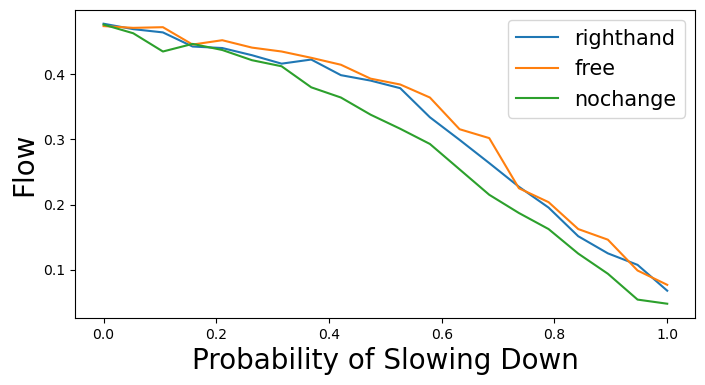

In [9]:
def visulization_pslow2flow():
    precision = 20
    num_of_sim = 10
    num_of_ite = 100
    p_slows = np.linspace(0, 1, precision)
    flows_righthand = np.zeros(precision)
    flows_free = np.zeros(precision)
    flows_nochange = np.zeros(precision)

    for i in range(precision):
        sum_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(p_slowdown = p_slows[i], density = 0.1)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_righthand)
            sum_flow += sim.flow
        flows_righthand[i] = sum_flow / num_of_sim

    for i in range(precision):
        sum_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(p_slowdown = p_slows[i], density = 0.1)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_free)
            sum_flow += sim.flow
        flows_free[i] = sum_flow / num_of_sim

    for i in range(precision):
        sum_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(p_slowdown = p_slows[i], density = 0.1)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_nochange)
            sum_flow += sim.flow
        flows_nochange[i] = sum_flow / num_of_sim

    plt.figure(figsize = (8, 4))
    plt.plot(p_slows, flows_righthand, label = 'righthand')
    plt.plot(p_slows, flows_free, label = 'free')
    plt.plot(p_slows, flows_nochange, label = 'nochange')
    plt.xlabel("Probability of Slowing Down", fontsize = 20)
    plt.ylabel("Flow", fontsize = 20)
    plt.legend(fontsize = 15)
    plt.show()

visulization_pslow2flow()

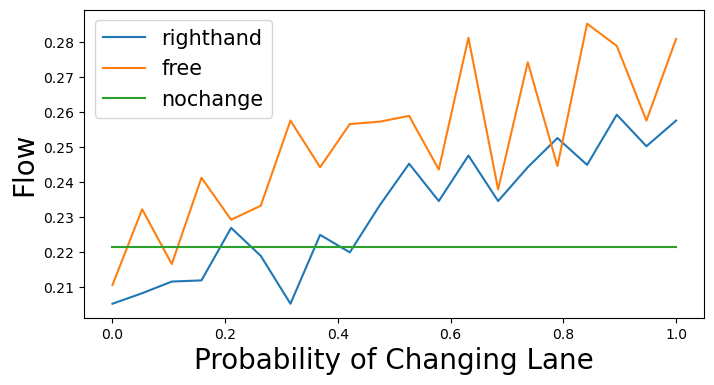

In [10]:
def visulization_pchange2flow():
    precision = 20
    num_of_sim = 10
    num_of_ite = 100
    p_changes = np.linspace(0, 1, precision)
    flows_righthand = np.zeros(precision)
    flows_free = np.zeros(precision)
    flows_nochange = np.zeros(precision)

    baseline_flow = 0.
    for j in range(num_of_sim):
        sim = MultiLaneTrafficSimulation(p_change_lane = 0, density = 0.1, p_slowdown = 0.7)
        sim.random_initialize()
        for k in range(num_of_ite):
            sim.sim_iteration(sim.change_lane_nochange)
        baseline_flow += sim.flow
    baseline_flow /= num_of_sim
    flows_nochange[:] = baseline_flow 

    for i in range(precision):
        sum_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(p_change_lane = p_changes[i], density = 0.1, p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_righthand)
            sum_flow += sim.flow
        flows_righthand[i] = sum_flow / num_of_sim

    for i in range(precision):
        sum_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(p_change_lane = p_changes[i], density = 0.1, p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_free)
            sum_flow += sim.flow
        flows_free[i] = sum_flow / num_of_sim

    plt.figure(figsize=(8, 4))
    plt.plot(p_changes, flows_righthand, label = 'righthand')
    plt.plot(p_changes, flows_free, label = 'free')
    plt.plot(p_changes, flows_nochange, label = 'nochange')
    plt.xlabel("Probability of Changing Lane", fontsize = 20)
    plt.ylabel("Flow", fontsize = 20)
    plt.legend(fontsize = 15)
    plt.show()


visulization_pchange2flow()

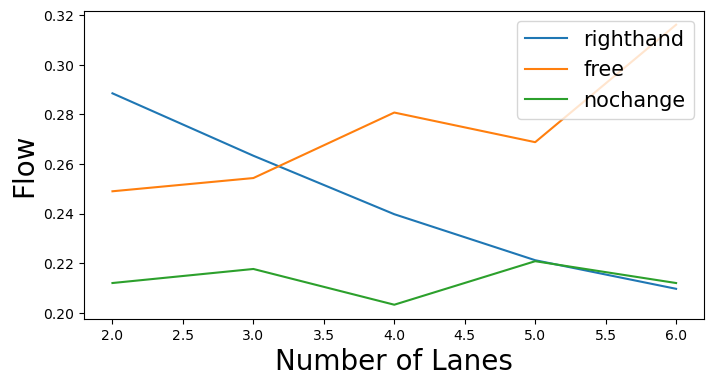

In [11]:
def visulization_lanes2flow():
    lane_values = np.arange(2, 7)  # Number of lanes from 1 to 10
    num_of_sim = 10
    num_of_ite = 100
    flows_righthand = np.zeros(len(lane_values))
    flows_free = np.zeros(len(lane_values))
    flows_nochange = np.zeros(len(lane_values))

    for i in range(len(lane_values)):
        sum_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(num_of_lanes = lane_values[i], density = 0.1, p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_righthand)
            sum_flow += sim.flow
        flows_righthand[i] = sum_flow / num_of_sim

    for i in range(len(lane_values)):
        sum_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(num_of_lanes = lane_values[i], density = 0.1, p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_free)
            sum_flow += sim.flow
        flows_free[i] = sum_flow / num_of_sim

    for i in range(len(lane_values)):
        sum_flow = 0.
        for j in range(num_of_sim):
            sim = MultiLaneTrafficSimulation(num_of_lanes = lane_values[i], density = 0.1, p_slowdown = 0.7)
            sim.random_initialize()
            for k in range(num_of_ite):
                sim.sim_iteration(sim.change_lane_nochange)
            sum_flow += sim.flow
        flows_nochange[i] = sum_flow / num_of_sim

    plt.figure(figsize = (8, 4))
    plt.plot(lane_values, flows_righthand, label = 'righthand')
    plt.plot(lane_values, flows_free, label = 'free')
    plt.plot(lane_values, flows_nochange, label = 'nochange')
    plt.xlabel("Number of Lanes", fontsize = 20)
    plt.ylabel("Flow", fontsize = 20)
    plt.legend(fontsize = 15)
    plt.show()

visulization_lanes2flow()

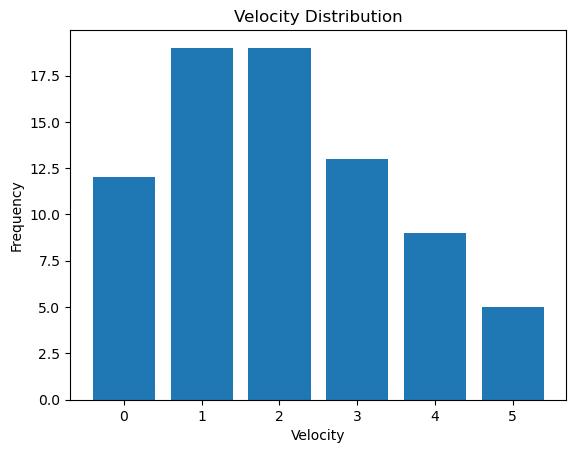

(-0.7941653187359994, 4.8720873966580776)

In [12]:
def confidence_interval(sim):
    num_of_cars = sim.num_of_lanes * sim.length - np.sum(sim.current_state == -1)
    speeds = sim.current_state.copy().reshape(1, -1)
    index = speeds.argsort()
    speeds = speeds[0, index[0, -num_of_cars:]]

    mean = np.mean(speeds)
    std = np.std(speeds)
    lower_bound = mean - 1.96 * std
    higher_bound = mean + 1.96 * std

    Vs = np.linspace(0, sim.Vmax, sim.Vmax + 1).astype(int)
    num_of_Vs = np.zeros(sim.Vmax + 1)
    for i in range(Vs.shape[0]):
        num_of_Vs[Vs[i]] = np.sum(speeds == Vs[i])

    plt.bar(Vs, num_of_Vs)
    plt.xlabel('Velocity')
    plt.ylabel('Frequency')
    plt.title('Velocity Distribution')
    plt.show()

    return lower_bound, higher_bound

sim = MultiLaneTrafficSimulation()
sim.random_initialize()
for _ in range(100):  
    sim.sim_iteration(sim.change_lane_free) 

confidence_interval(sim)